# __Reviewer feedback analysis 1__

- Cause of growth in China/India publication volume

## ___Setup___

In [1]:
# for counting the 17 journals
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.optimize import curve_fit

proj_dir = Path.home() / "projects/plant_sci_hist"

## ___Number of papers from the top 17 plant science journals___

Reviewer 1 indicated that:

"Similarly, it is unclear to which extent the growth reported for China and India is truly exceptional growth of plant research in these countries, or increased publishing in English, or efforts of NCBI to include literature written in languages other than English. While such a distinction could be obtained by analyzing plant-related publications contained in OpenAlex, a few extra words would seem to suffice."

Finding:
- The top 17 journals have very similar trend as the overall result from the entire corpus. Since the top 17 journals are all in English, it does not seem that increased publishing in English is the reason.
- In later section, we found that Plant Science Corpus has 97% of records from journals in English. Thus, the impact of non-English journal is expected to be minimal and the pattern we see is unlikely to be influenced by efforts of NCBI to include non-English literature.
- Therefore, there appears to be exceptional growth in plant reseach publications in higher impact journals from India and China which cannot be explained by the above two factors.

In [2]:
dir92 = proj_dir / "9_wrap_up/9_2_ci_j17"
dir92.mkdir(parents=True, exist_ok=True)

# Topic dataframe
dir42       = proj_dir / "4_topic_model/4_2_outlier_assign"
corpus_file = dir42 / "table7_5_corpus_with_topic_assignment_nodup.tsv.gz"
tdf         = pd.read_csv(corpus_file, sep='\t', compression='gzip', 
                          index_col=[0])

In [3]:
# Country information
dir75   = proj_dir / "7_countries/7_5_country_over_time"
ci_file = dir75 / 'ci_pmid_topic.tsv'
ci      = pd.read_csv(ci_file, sep='\t')

ci.head(2)

PMID   A3  Confidence        Date  Topic  Year
0   400957  CAN           3  1978-01-01     50  1978
1  1279107  FRA           3  1992-11-01     12  1992

In [4]:
# get subset of columns in tdf
pmid_j = tdf[['PMID', 'Journal']]

# join country data with tdf
ci_j = pd.merge(ci, pmid_j, on='PMID')

tdf.shape, ci.shape, ci_j.shape

((421307, 12), (330328, 6), (330328, 7))

In [5]:
ci_j.head(2)

PMID   A3  Confidence        Date  Topic  Year  \
0   400957  CAN           3  1978-01-01     50  1978   
1  1279107  FRA           3  1992-11-01     12  1992   

                                             Journal  
0  Comparative biochemistry and physiology. B, Co...  
1                    The Journal of general virology

In [6]:
# Filter ci_j based on the top 17 journals
psj17 = ['Plant physiology', 'Frontiers in plant science', 'Planta',
          'The Plant journal : for cell and molecular biology', 
          'Journal of experimental botany', 'Plant molecular biology',
          'The New phytologist', 'The Plant cell', 'Phytochemistry',
          'Plant &amp; cell physiology', 'American journal of botany',
          'Annals of botany', 'BMC plant biology', 'Tree physiology',
          'Molecular plant-microbe interactions : MPMI',
          '"Plant biology (Stuttgart, Germany)"', 
          'Plant biotechnology journal']

ci_j17 = ci_j[ci_j['Journal'].isin(psj17)]

ci_j17.shape, ci_j17.shape[0] / ci_j.shape[0]

((72777, 7), 0.22031738151170957)

/tmp/ipykernel_94728/4049704135.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  num_yr_ci_j17 = ci_j17['Year'].value_counts().sort_index()[:-1]


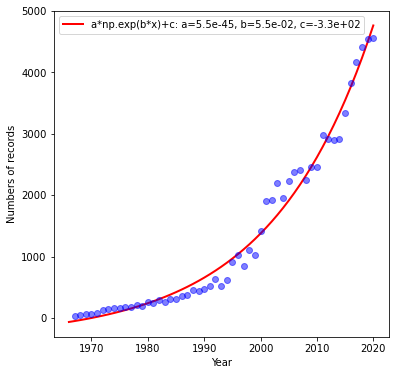

In [7]:
# count number of articles per year, rid of data from 2021
num_yr_ci_j17 = ci_j17['Year'].value_counts().sort_index()[:-1]

# following codes are from 4.4
X = num_yr_ci_j17.index
Y = num_yr_ci_j17.values

def exp_func(X, a, b, c):
  return a*np.exp(b*X) + c

# Curve fit
popt_exp, _ = curve_fit(exp_func, X, Y, p0=(1, 1e-6, 1), maxfev=10000)
popt_exp

# Plotting
fig_fit_yr_docnum = dir92 / "fig9_2_year_docnum_exponential_fit_j17.pdf"

#y_pred = [exp_func(x, *popt_exp) for x in X]
plt.figure(figsize=(6, 6))
plt.plot(X, exp_func(X, *popt_exp),'r',linewidth=2, 
        label='a*np.exp(b*x)+c: a=%.1e, b=%.1e, c=%.1e' % tuple(popt_exp))
plt.plot(X[1:], Y[1:], 'bo', alpha=0.5)
#plt.plot(x[1:], y_pred[1:], '-b')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Numbers of records")
plt.savefig(fig_fit_yr_docnum, format='pdf')
plt.show()

In [8]:
# Single out USA, GRB, IND, and CHN for counts
ci_j17_usa = ci_j17[ci_j17['A3'] == 'USA']
ci_j17_grb = ci_j17[ci_j17['A3'] == 'GBR']
ci_j17_ind = ci_j17[ci_j17['A3'] == 'IND']
ci_j17_chn = ci_j17[ci_j17['A3'] == 'CHN']

# count number of articles per year, rid of data from 2021
num_yr_ci_j17_usa = ci_j17_usa['Year'].value_counts().sort_index().iloc[:-1]
num_yr_ci_j17_grb = ci_j17_grb['Year'].value_counts().sort_index().iloc[:-1]
num_yr_ci_j17_ind = ci_j17_ind['Year'].value_counts().sort_index().iloc[:-1]
num_yr_ci_j17_chn = ci_j17_chn['Year'].value_counts().sort_index().iloc[:-1]

# Normalized counts based on total from each country
norm_usa = num_yr_ci_j17_usa / sum(num_yr_ci_j17_usa)*100
norm_grb = num_yr_ci_j17_grb / sum(num_yr_ci_j17_grb)*100
norm_ind = num_yr_ci_j17_ind / sum(num_yr_ci_j17_ind)*100
norm_chn = num_yr_ci_j17_chn / sum(num_yr_ci_j17_chn)*100

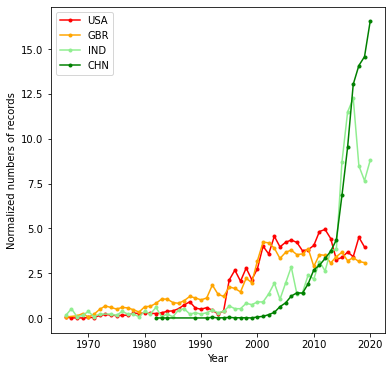

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(norm_usa, ".-", c="red")
plt.plot(norm_grb, ".-", c="orange")
plt.plot(norm_ind, ".-", c="lightgreen")
plt.plot(norm_chn, ".-", c="green")
plt.legend(['USA', 'GBR', 'IND', 'CHN'])
plt.xlabel("Year")
plt.ylabel("Normalized numbers of records")
plt.savefig(dir92 / "fig9_2_year_docnum_normalized_4countries.pdf", 
            format='pdf')
plt.show()